In [30]:
import matplotlib.pyplot as plt
import math
import numpy as np

from shapely.geometry import Polygon, LineString, Point, MultiPolygon
import matplotlib.pyplot as plt

def longest_polygon_side_coords(vertices):
    max_length = 0
    longest_side = None
    n = len(vertices)
    
    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]  # Замыкаем многоугольник
        length = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        
        if length > max_length:
            max_length = length
            longest_side = [(x1, y1), (x2, y2)]  # Сохраняем координаты
    
    return longest_side

def scale_segment(segment, scale_factor=3):
    # Получаем координаты точек
    (x1, y1), (x2, y2) = segment
    
    # Находим середину отрезка
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    # Увеличиваем расстояние от центра до каждой точки
    new_x1 = center_x + (x1 - center_x) * scale_factor
    new_y1 = center_y + (y1 - center_y) * scale_factor
    new_x2 = center_x + (x2 - center_x) * scale_factor
    new_y2 = center_y + (y2 - center_y) * scale_factor
    
    return [(new_x1, new_y1), (new_x2, new_y2)]

def parallel_line(line, distance):
    # Извлекаем точки линии
    p1, p2 = line
    x1, y1 = p1
    x2, y2 = p2
    
    # Вычисляем вектор направления линии
    dx = x2 - x1
    dy = y2 - y1
    
    # Вычисляем длину отрезка
    length = math.sqrt(dx**2 + dy**2)
    
    if length == 0:
        raise ValueError("Линия имеет нулевую длину")
    
    # Нормализуем вектор направления
    nx = -dy / length
    ny = dx / length
    
    # Смещаем точки на заданное расстояние перпендикулярно линии
    offset_x1 = x1 + nx * distance
    offset_y1 = y1 + ny * distance
    offset_x2 = x2 + nx * distance
    offset_y2 = y2 + ny * distance
    
    # Возвращаем параллельную линию
    return [[offset_x1, offset_y1], [offset_x2, offset_y2]]

In [14]:
def find_polygon_line_intersections(polygon, line):
    """
    Находит все точки пересечения многоугольника и прямой.
    """
    intersections = []
    line_p1, line_p2 = line
    
    # Проверяем пересечение прямой с каждой стороной многоугольника
    for i in range(len(polygon)):
        p1 = polygon[i]
        p2 = polygon[(i + 1) % len(polygon)]
        
        intersection = find_intersection(p1, p2, line_p1, line_p2)
        if intersection:
            intersections.append(intersection)
    
    return intersections

def find_intersection(p1, p2, p3, p4):
    """
    Находит точку пересечения двух отрезков p1-p2 и p3-p4.
    Возвращает None, если отрезки не пересекаются.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    x4, y4 = p4
    
    # Уравнение прямой для первого отрезка: A1x + B1y = C1
    A1 = y2 - y1
    B1 = x1 - x2
    C1 = A1 * x1 + B1 * y1
    
    # Уравнение прямой для второго отрезка: A2x + B2y = C2
    A2 = y4 - y3
    B2 = x3 - x4
    C2 = A2 * x3 + B2 * y3
    
    # Определитель
    det = A1 * B2 - A2 * B1
    
    if det == 0:
        return None  # Прямые параллельны
    
    # Точка пересечения прямых
    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det
    
    # Проверяем, что точка лежит на обоих отрезках
    if (min(x1, x2) <= x <= max(x1, x2) and min(y1, y2) <= y <= max(y1, y2) and
        min(x3, x4) <= x <= max(x3, x4) and min(y3, y4) <= y <= max(y3, y4)):
        return (x, y)
    
    return None

In [15]:
def draw_perpendicular_line(line, point_index=0, length=10):
    """
    Строит перпендикулярную линию через указанную точку исходной линии.
    
    Параметры:
    line - исходная линия в формате [[x1, y1], [x2, y2]]
    point_index - индекс точки (0 или 1), через которую проходит перпендикуляр
    length - длина перпендикулярной линии в обе стороны от точки
    
    Возвращает:
    Перпендикулярную линию в формате [[x_start, y_start], [x_end, y_end]]
    """
    # Получаем координаты исходной линии
    p1, p2 = np.array(line[0]), np.array(line[1])
    
    # Выбираем точку, через которую проводим перпендикуляр
    point = p1 if point_index == 0 else p2
    
    # Находим направляющий вектор исходной линии
    direction_vector = p2 - p1
    
    # Находим перпендикулярный вектор (поворот на 90 градусов)
    perpendicular_vector = np.array([-direction_vector[1], direction_vector[0]])
    
    # Нормализуем перпендикулярный вектор
    unit_perpendicular = perpendicular_vector / np.linalg.norm(perpendicular_vector)
    
    # Вычисляем конечные точки перпендикулярной линии
    start_point = point - unit_perpendicular * length
    end_point = point + unit_perpendicular * length
    
    # Возвращаем перпендикулярную линию
    return [start_point.tolist(), end_point.tolist()]

In [16]:
def remove_duplicate_points(points, tolerance=1e-5):
    """
    Удаляет дубликаты точек с учетом погрешности.
    
    Аргументы:
        points: список точек в формате [x, y] или (x, y)
        tolerance: допустимая погрешность при сравнении координат
    
    Возвращает:
        Список уникальных точек
    """
    unique_points = []
    
    for point in points:
        # Приводим точку к кортежу (если это список)
        current = tuple(point)
        
        # Проверяем, есть ли уже такая точка в unique_points
        is_duplicate = False
        for existing in unique_points:
            # Сравниваем координаты с учетом погрешности
            if (math.isclose(current[0], existing[0], abs_tol=tolerance) and 
                math.isclose(current[1], existing[1], abs_tol=tolerance)):
                is_duplicate = True
                break
        
        if not is_duplicate:
            unique_points.append(current)
    
    return unique_points

In [17]:
def point_on_segment(a, b, c, tol=1e-8):
    """Проверяет, лежит ли точка c на отрезке ab с учетом погрешности."""
    cross = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    if abs(cross) > tol:
        return False
    
    min_x = min(a[0], b[0]) - tol
    max_x = max(a[0], b[0]) + tol
    min_y = min(a[1], b[1]) - tol
    max_y = max(a[1], b[1]) + tol
    
    return (min_x <= c[0] <= max_x) and (min_y <= c[1] <= max_y)

def points_equal(a, b, tol=1e-8):
    """Проверяет, совпадают ли две точки с учетом погрешности."""
    return (abs(a[0] - b[0]) < tol) and (abs(a[1] - b[1]) < tol)

def insert_points_to_polygon(polygon, points):
    """Вставляет точки в стороны многоугольника, если они на них лежат, избегая дубликатов."""
    new_polygon = []
    
    for i in range(len(polygon) - 1):
        a = polygon[i]
        b = polygon[i + 1]
        new_polygon.append(a)
        
        # Находим все точки, лежащие на текущем отрезке (исключая концы)
        segment_points = []
        for point in points:
            if point_on_segment(a, b, point) and not points_equal(a, point) and not points_equal(b, point):
                # Проверяем, что точка еще не добавлена
                if not any(points_equal(point, p) for p in segment_points):
                    segment_points.append(point)
        
        # Сортируем точки по расстоянию от точки a
        if segment_points:
            segment_points.sort(key=lambda p: (p[0] - a[0])**2 + (p[1] - a[1])**2)
            new_polygon.extend(segment_points)
    
    return new_polygon

In [18]:
def find_other_point(segments, point, tolerance=1e-6):
    for segment in segments:
        for i, segment_point in enumerate(segment):
            # Проверяем, что обе координаты отличаются не более чем на tolerance
            if (abs(segment_point[0] - point[0]) <= tolerance and 
                abs(segment_point[1] - point[1]) <= tolerance):
                return segment[1 - i]  # Возвращаем вторую точку отрезка
    return None 

In [19]:
def normalize_points(polygon):
    return [(point[0], point[1]) if isinstance(point, (list, tuple)) else tuple(point) for point in polygon]

In [20]:
def find_index_with_tolerance(points_list, target_point, tolerance=1e-6):
    for i, point in enumerate(points_list):
        if (abs(point[0] - target_point[0]) <= tolerance and 
            abs(point[1] - target_point[1]) <= tolerance):
            return i
    raise ValueError(f"Точка {target_point} не найдена в списке (с учётом погрешности {tolerance})")

In [31]:
def convert_coords(polygon):
    return [tuple(coord) if isinstance(coord, list) else coord for coord in polygon]

In [32]:
def myfunc(rectangle, a, b):
    longest_line = longest_polygon_side_coords(rectangle)
    inc_line = scale_segment(longest_line)

    dist = a
    cmpdist = 0
    inter = []
    while 1:
        parallel1 = parallel_line(inc_line, cmpdist)
        cmpdist += dist
        if find_polygon_line_intersections(rectangle, parallel1) == []:
            break
        else:
            inter.append(find_polygon_line_intersections(rectangle, parallel1))
    
    dist = -a
    cmpdist = -a
    while 1:
        parallel1 = parallel_line(inc_line, cmpdist)
        cmpdist += dist
        if find_polygon_line_intersections(rectangle, parallel1) == []:
            break
        else:
            inter.append(find_polygon_line_intersections(rectangle, parallel1))

    longest_line = longest_polygon_side_coords(rectangle)
    perpendicular = scale_segment(draw_perpendicular_line(longest_line, point_index=1, length=3))
    
    dist = b
    cmpdist = 0
    inter1 = []
    while 1:
        parallel1 = parallel_line(perpendicular, cmpdist)
        cmpdist += dist
        if find_polygon_line_intersections(rectangle, parallel1) == []:
            break
        else:
            inter1.append(find_polygon_line_intersections(rectangle, parallel1))

    dist = -b
    cmpdist = 0
    while 1:
        parallel1 = parallel_line(perpendicular, cmpdist)
        cmpdist += dist
        if find_polygon_line_intersections(rectangle, parallel1) == []:
            break
        else:
            inter1.append(find_polygon_line_intersections(rectangle, parallel1))

    points = []
    for point in rectangle:
        points.append(point)
    for i, segment in enumerate(inter):
        points.append(segment[0])
        points.append(segment[1])
    for i, segment in enumerate(inter1):
        points.append(segment[0]) 
        points.append(segment[1])
        
    unique_points = remove_duplicate_points(points)

    ans = []
    for i, segment in enumerate(inter):
        for j, segment2 in enumerate(inter1):
            if find_intersection(segment[0], segment[1], segment2[0], segment2[1]) == None:
                continue
            else:
                a, b = find_intersection(segment[0], segment[1], segment2[0], segment2[1])
                ans.append((a, b))
    Remans = remove_duplicate_points(ans)
    
    new_points = []
    for i, segment in enumerate(inter):
        new_points.append(segment[0])
        new_points.append(segment[1])
    new_points

    new_rectangle = insert_points_to_polygon(rectangle, new_points)
    colors = []
    visited = []
    
    x, y = zip(*rectangle)
    
    x_new, y_new = zip(*new_rectangle)
    
    for i, (px, py) in enumerate(new_rectangle):
        is_original = any(points_equal((px, py), p) for p in rectangle)
        color = 'blue' if is_original else 'red'
        colors.append(color)
        visited.append(0)

    ind = 0
    rectangles = []
    tmp = []
    visited = [0] * len(new_rectangle)
    tr = 0
    
    while any(x == 0 for x in visited):
        if (colors[ind] == 'blue' or visited[ind] == 1) and tr == 0:
            ind += 1
            if ind == len(new_rectangle):
                ind = 0
        else:
            tr = 1
            while visited[(ind + 1) % len(new_rectangle)] == 1:
                ind += 1
                if ind == len(new_rectangle):
                    ind = 0
            tmp.append(new_rectangle[ind])
            tmp.append(find_other_point(inter, new_rectangle[ind]))
            visited[ind] = 1
            ind2 = new_rectangle.index(find_other_point(inter, new_rectangle[ind]))
            visited[ind2] = 1
            ind += 1 
            if ind == len(new_rectangle):
                ind = 0
            ind2 -= 1
            if ind2 == -1:
                ind2 = len(new_rectangle) - 1
            while colors[ind] == 'blue' and visited[ind] == 0:
                tmp.insert(0, new_rectangle[ind])
                visited[ind] = 1
                ind += 1
                if ind == len(new_rectangle):
                    ind = 0
            while colors[ind2] == 'blue' and visited[ind2] == 0:
                tmp.append(new_rectangle[ind2])
                visited[ind2] = 1
                ind2 -= 1
                if ind2 == -1:
                    ind2 = len(new_rectangle) - 1
            if colors[ind] == 'red' and visited[ind] == 0:
                tmp.insert(0, new_rectangle[ind])
                tmp.append(find_other_point(inter, new_rectangle[ind]))
                visited[ind] = 1
                ind2 = new_rectangle.index(find_other_point(inter, new_rectangle[ind]))
                visited[ind2] = 1
            rectangles.append(tmp)
            tmp = []

    rectangles1 = rectangles

    new_points = []
    for i, segment in enumerate(inter1):
        new_points.append(segment[0])
        new_points.append(segment[1])
    new_points

    new_rectangle = insert_points_to_polygon(rectangle, new_points)
    colors = []
    visited = []
    
    x_new, y_new = zip(*new_rectangle)
    
    for i, (px, py) in enumerate(new_rectangle):
        is_original = any(points_equal((px, py), p) for p in rectangle)
        color = 'blue' if is_original else 'red'
        colors.append(color)
        visited.append(0)

    ind = 0
    rectangles = []
    tmp = []
    visited = [0] * len(new_rectangle)
    tr = 0
    while any(x == 0 for x in visited):
        if (colors[ind] == 'blue' or visited[ind] == 1) and tr == 0:
            ind += 1
            if ind == len(new_rectangle):
                ind = 0
        else:
            tr = 1
            while visited[(ind + 1) % len(new_rectangle)] == 1:
                ind += 1
                if ind == len(new_rectangle):
                    ind = 0
            tmp.append(new_rectangle[ind])
            tmp.append(find_other_point(inter1, new_rectangle[ind]))
            visited[ind] = 1
            other_point = find_other_point(inter1, new_rectangle[ind])
            ind2 = find_index_with_tolerance(new_rectangle, other_point)
            visited[ind2] = 1
            ind += 1 
            if ind == len(new_rectangle):
                ind = 0
            ind2 -= 1
            if ind2 == -1:
                ind2 = len(new_rectangle) - 1
            while colors[ind] == 'blue' and visited[ind] == 0:
                tmp.insert(0, new_rectangle[ind])
                visited[ind] = 1
                ind += 1
                if ind == len(new_rectangle):
                    ind = 0
            while colors[ind2] == 'blue' and visited[ind2] == 0:
                tmp.append(new_rectangle[ind2])
                visited[ind2] = 1
                ind2 -= 1
                if ind2 == -1:
                    ind2 = len(new_rectangle) - 1
            if colors[ind] == 'red' and visited[ind] == 0:
                #print(3)
                tmp.insert(0, new_rectangle[ind])
                tmp.append(find_other_point(inter1, new_rectangle[ind]))
                visited[ind] = 1
                other_point = find_other_point(inter1, new_rectangle[ind])
                ind2 = find_index_with_tolerance(new_rectangle, other_point)
                visited[ind2] = 1
            rectangles.append(tmp)
            tmp = []

    rectangles2 = rectangles

    fig, ax = plt.subplots(figsize=(10, 8))
    intersection_counter = 1
    
    for i, poly1_coords in enumerate(rectangles1):
        for j, poly2_coords in enumerate(rectangles2):
            # Преобразуем координаты и создаем полигоны
            poly1 = Polygon(convert_coords(poly1_coords))
            poly2 = Polygon(convert_coords(poly2_coords))
                
            # Находим пересечение
            intersection = poly1.intersection(poly2)
                
            if intersection.is_empty:
                continue
            else:
                xi, yi = intersection.exterior.xy
    
                print(f"Пересечение #{intersection_counter}:")
                print(f"Между полигоном {i} из polygons1 и полигоном {j} из polygons2")
                print("Координаты границы пересечения:")
                
                # Печатаем координаты в виде списка кортежей (x, y)
                coords = list(zip(xi, yi))
                for coord in coords:
                    print(f"({coord[0]:.6f}, {coord[1]:.6f})")
                print("\n")  # Пустая строка для разделения
                
                ax.fill(xi, yi, alpha=0.5)
                centroid = intersection.centroid
                ax.text(centroid.x, centroid.y, str(intersection_counter), 
                                ha='center', va='center', fontsize=10, weight='bold')
                        
                intersection_counter += 1
    
    plt.title('Пересечение многоугольников')
    plt.grid(True)
    plt.axis('equal')
    plt.show()

Пересечение #1:
Между полигоном 0 из polygons1 и полигоном 0 из polygons2
Координаты границы пересечения:
(2.089572, 0.727607)
(1.119430, 0.970143)
(1.847037, 3.880570)
(2.817179, 3.638034)
(2.089572, 0.727607)


Пересечение #2:
Между полигоном 0 из polygons1 и полигоном 1 из polygons2
Координаты границы пересечения:
(2.817179, 3.638034)
(1.847037, 3.880570)
(2.376894, 6.000000)
(3.407671, 6.000000)
(2.817179, 3.638034)


Пересечение #3:
Между полигоном 0 из polygons1 и полигоном 2 из polygons2
Координаты границы пересечения:
(1.926137, 0.073863)
(1.101515, 0.898485)
(1.119430, 0.970143)
(2.089572, 0.727607)
(1.926137, 0.073863)


Пересечение #4:
Между полигоном 1 из polygons1 и полигоном 0 из polygons2
Координаты границы пересечения:
(0.276894, 1.723106)
(0.876894, 4.123106)
(1.847037, 3.880570)
(1.119430, 0.970143)
(1.000000, 1.000000)
(0.689205, 1.310795)
(0.276894, 1.723106)


Пересечение #5:
Между полигоном 1 из polygons1 и полигоном 1 из polygons2
Координаты границы пересечения:


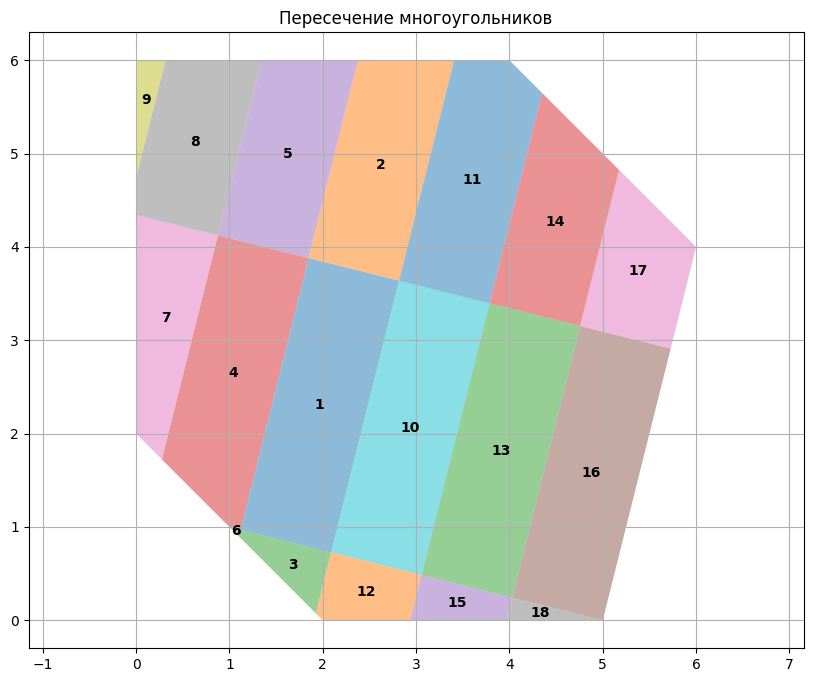

In [35]:
rectangle = [[2, 0], [0, 2],[0, 6], [4, 6], [6, 4], [5, 0], [2, 0]]
myfunc(rectangle, 1, 3)